In [31]:
##### import fiona
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
# import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)

#### Functions

In [3]:
def readNHD(index):
    ## Set-up
    mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
# NEED WITH WATERBODY FOR CUSHMAN!!!!
    prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/' # _with_waterbody

    # Define dtypes for lookup tables to preserve leading zeros
    dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
    # Read in HUC lookup table
    lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

    # Get current HUC2 and HUC4 IDs
    hu2 = 'HUC2_' + lookup.loc[index,'HUC4'][0:2]
    hu4 = 'NHDPLUS_H_' + lookup.loc[index,'HUC4'] + '_HU4_GDB'
    
    # Set data filepath
    file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg') # _with_waterbody

    ## Read in prepped NHD flowlines
    features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
    basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')
    
    # Make geometry 2D LineStrings
    basin['geometry'] = basin.geometry.explode().force_2d()
    
    return basin

In [4]:
def cut(line, distance):
    # Cuts a line in two at a distance from its starting point
    # Returns the trimmed piece and the remainder of the linestring
    if distance <= 0.0 or distance >= line.length:
        return [LineString(line)]
    coords = list(line.coords)
    for i, p in enumerate(coords):
        pd = line.project(Point(p))
        if pd == distance:
            return [
                LineString(coords[:i+1]),
                LineString(coords[i:])]
        if pd > distance:
            cp = line.interpolate(distance)
            return [
                LineString(coords[:i] + [(cp.x, cp.y)]),
                LineString([(cp.x, cp.y)] + coords[i:])]

In [5]:
def bitwiseMask(ds):
    # Fow now, remove pixels with land classification and
    # geolocation_qual very not good
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    mask = np.where(np.logical_and(ds.classification > 1, ds.geolocation_qual < 2**12))[0]
    print(mask.shape)
    return mask

In [6]:
def makeGDF(ds, mask, data_var):
    # This function takes the pixel cloud, makes a GeoDataFrame,
    # renames columns as needed, projects the CRS, and returns
    # the GDF 

    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(ds[data_var][mask],
                                geometry=gpd.points_from_xy(
                                    ds.longitude[mask],
                                    ds.latitude[mask]),
                                crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    if data_var == 'classification':
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
    else:
        gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: data_var}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    
    return gdf_PIXC

In [7]:
def segmentReach(reach):
    '''
    Ths function XXX
    '''
    # Get linestring
    line = reach.geometry
    # Find length of segments
    dist = line.length/10
    
    # Make empty list for segments
    segments = []

    # Segment the reach
    for i in range(9):
        try:
            # Chop the reach, store remainder
            new, line = cut(line=line, distance=dist)
            # Append new segment to GeoSeries of all segments
            segments.append(new)
            # segments[i]: new
        except:
            print(reach['NHDPlusID'])
    
    # Append final segment to list
    segments.append(line)

    return segments

#### Read in and prep NHD

In [12]:
# Set slurm job index
i = 4 # HUC4 0108, Connecticut
# i = 109 # HUC4 1711, Snoqualmie
# i = 57 # HUC4 0807, Mississippi
# i = 191 # HUC4 1708, Columbia

In [13]:
# Read prepped NHD
basin = readNHD(index=i)

In [14]:
basin

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
0,"(0, 10]",None,0.36,10000900074595.00,2.50,"LINESTRING (-8132916.01 5289901.543, -8132916...."
1,"(0, 10]",None,0.60,10000900043332.00,1.54,"LINESTRING (-8061020.932 5374240.653, -8061022..."
2,"(0, 10]",None,0.21,10000900077596.00,1.29,"LINESTRING (-8087730.068 5179341.463, -8087730..."
3,"(0, 10]",None,0.11,10000900087485.00,2.67,"LINESTRING (-8121499.756 5322310.966, -8121501..."
4,"(50, 60]",Ammonoosuc River,1.88,10000900022936.00,50.93,"LINESTRING (-8008860.725 5493474.985, -8008861..."
...,...,...,...,...,...,...
64749,"(0, 10]",Legate Hill Brook,1.14,10000900038209.00,3.63,"LINESTRING (-8116396.119 5262446.77, -8116368...."
64750,"(0, 10]",Middle Branch Indian Stream,0.89,10000900012117.00,2.50,"LINESTRING (-7935262.401 5668274.395, -7935271..."
64751,"(0, 10]",None,2.66,10000900024205.00,2.98,"LINESTRING (-7951969.936 5527770.608, -7951985..."
64752,"(0, 10]",None,1.60,10000900011942.00,2.46,"LINESTRING (-7945927.353 5522423.902, -7945917..."


In [15]:
np.max(basin['WidthM'])

np.float64(219.80273587283008)

#### Read in and prep PIXC

In [16]:
pixc_path = '../data/small_rivers/mar_2024_ver_c/leaf_off/SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01.nc'
# pixc_path = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_011_345_239R_20240227T044209_20240227T044220_PIC0_01.nc'

In [17]:
tile_name = pixc_path[-71:-3]
tile_name

'SWOT_L2_HR_PIXC_014_341_229R_20240429T152954_20240429T153005_PIC0_01'

In [18]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group='pixel_cloud', engine='h5netcdf')

In [13]:
# # Make dict for legend labels
# flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
# codes = {idx:k for idx, k in enumerate(flags, start=1)}

In [14]:
# counts = pd.DataFrame(ds_PIXC.geolocation_qual).value_counts().sort_index()
# counts

In [19]:
# Make mask
mask = bitwiseMask(ds=ds_PIXC)

# # If dataframe not empty after filtering
# if mask.shape != (0,):
#     # Make PIXC
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_var='classification')
    # # Append to list
    # d.append(gdf_PIXC)

(1552029,)


In [20]:
def getCoverage(reach, gdf_PIXC=gdf_PIXC):
    '''
    Ths function takes a segmented reach, explodes it to get one row
    per reach, buffers the reach segments with 1/2 the calculated width
    on either of the reach segment centerlines, intersects the buffered
    segments with the SWOT PIXC, and calculates the percent coverage for
    the whole reach, and returns this proportion.
    
    Right now, a segment only needs to have one pixel in it to be
    considered "detected".
    '''
    
    # Make GeoSeries with just segments
    segments = gpd.GeoSeries(data=reach['segments'], crs=basin_crop.crs)

    # Buffer segments by 1/2 the calculated width
    # CITE BEIGER
    segments = segments.buffer(distance=(reach.WidthM/2),cap_style='flat')
    
    # Make GeoDataFrame of segments
    segments = gpd.GeoDataFrame(geometry=segments)
    
    # Get pixels in reach
    inside = gpd.sjoin(gdf_PIXC, segments, how='inner',
                       predicate='within').rename(columns={'index_right': 'segment'})

    if inside.empty:
        prop = 0
    else:    
        # Get number of pixels in each reach segment
        counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
        # Calculate coverage (proportion of reaches with >= 1 pixel in them)
        prop = len(counts.loc[counts['count'] != 0])/10
    return prop

#### Get bounds of PIXC and crop basin to it

In [21]:
# Get bounds of PIXC, construct polygon
bounds_PIXC = gdf_PIXC.total_bounds
poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [22]:
basin_crop = basin.clip(poly)

In [23]:
# FOR NOW: Drop reaches with MultiLineString type
# This occurs because some reaches flow out of and then back
# into the PIXC tile of interest.
basin_crop = basin_crop[basin_crop.geometry.geometry.type=='LineString']

In [24]:
# Order of all possible bins for plotting
order = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]',
         '(50, 60]', '(60, 70]', '(70, 80]', '(80, 90]', '(90, 100]',
         '(100, 150]', '(150, 200]', '(200, 500]', '(500, 1000]']

In [25]:
# Find width bins present in cropped hydrography
bins = list(np.unique(basin_crop.Bin))
bins

['(0, 10]',
 '(10, 20]',
 '(150, 200]',
 '(20, 30]',
 '(200, 500]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]']

In [26]:
# Make sorted list of bins present
ordered = []
for binn in order:
    if binn in bins:
        ordered.append(binn)
ordered

['(0, 10]',
 '(10, 20]',
 '(20, 30]',
 '(30, 40]',
 '(40, 50]',
 '(50, 60]',
 '(60, 70]',
 '(150, 200]',
 '(200, 500]']

In [61]:
# basin_crop.plot()

#### Segment reach, calculates coverage functions

In [26]:
# # test = basin_crop[basin_crop['GNIS_Name'] == 'Connecticut River'].sample(n=5)
# test = basin_crop.sample(n=10000)
# test

In [32]:
# Try with apply()
basin_crop['segments'] = basin_crop.apply(segmentReach, axis=1)

In [33]:
basin_crop['coverage'] = basin_crop.apply(getCoverage, axis=1)

In [34]:
pd.DataFrame(basin_crop.coverage.value_counts().reset_index().sort_index())

,coverage,count
0,0.00,8277
1,0.10,984
2,0.20,371
3,0.30,186
4,1.00,167
5,0.40,113
6,0.50,79
7,0.60,64
8,0.90,52
9,0.80,42


In [35]:
mean_cov = basin_crop.groupby('Bin')['coverage'].mean()

In [36]:
mean_cov

Bin
(0, 10]      0.02
(10, 20]     0.12
(150, 200]   0.83
(20, 30]     0.22
(200, 500]   0.45
(30, 40]     0.44
(40, 50]     0.38
(50, 60]     0.27
(60, 70]     0.76
Name: coverage, dtype: float64

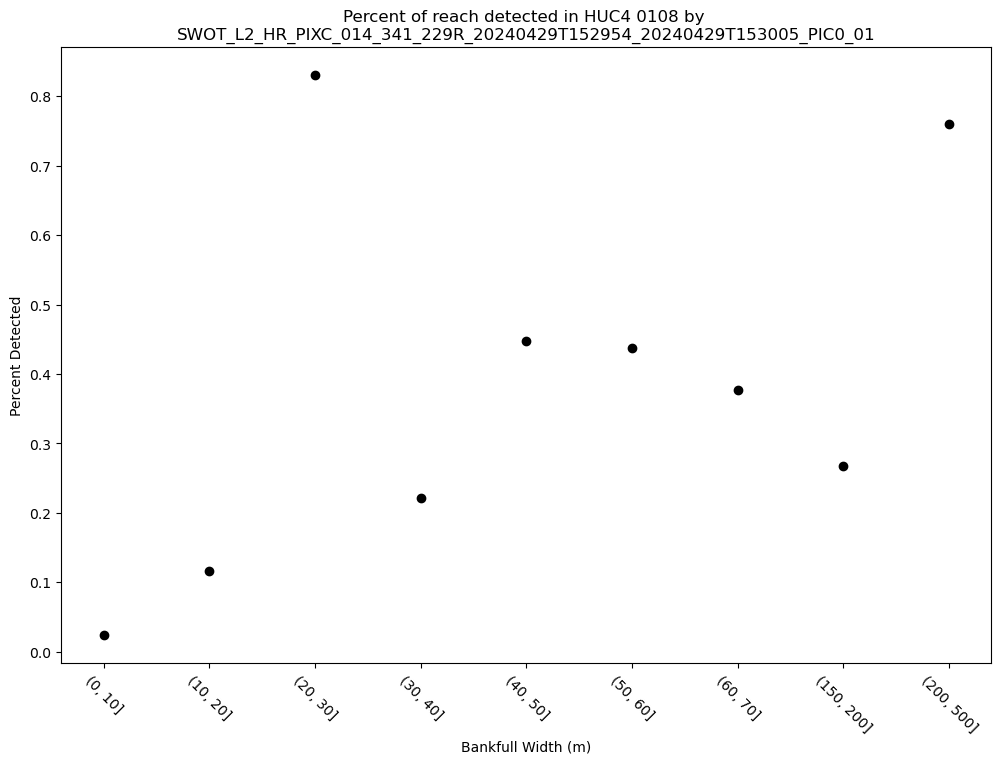

In [37]:
# plt.scatter(x=ordered, y=coverage, c='k')
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(x=mean_cov.keys(), y=mean_cov.values, c='k')
plt.title('Percent of reach detected in HUC4 0108 by \n'
          + tile_name)
plt.xticks(rotation=-45);

# Set number of ticks for x-axis
ax.set_xticks(range(len(ordered)))
# Set ticks labels for x-axis
ax.set_xticklabels(ordered)

plt.xlabel('Bankfull Width (m)')
plt.ylabel('Percent Detected')
plt.savefig(fname='./figures_for_unit_test/one_tile_one_reach_per_bin.png', bbox_inches='tight')

**CLEANUP**

In [131]:
line = line[test.index[0]]

In [147]:
type(line)

shapely.geometry.multilinestring.MultiLineString

In [137]:
line.length

149.7904202398326

In [133]:
dist = line.length/10

In [134]:
dist

14.97904202398326

In [135]:
segments = []

In [ ]:
# Segment the reach
for i in range(9):
    print(i)
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    # Append new segment to GeoSeries of all segments
    segments.append(new)

In [144]:
dist <= 0.0

False

In [145]:
dist >= line.length

False

In [146]:
coords = list(line.coords)

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

In [185]:
testy = tt.buffer(distance=(t.WidthM/2),cap_style='flat')

<Axes: >

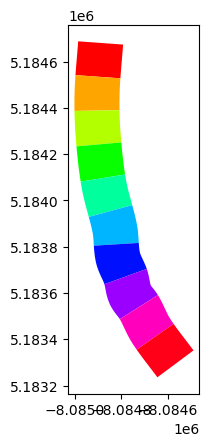

In [187]:
testy.plot(cmap='hsv')

In [195]:
testy = gpd.GeoDataFrame(geometry=testy)

In [196]:
testy

,geometry
0,"POLYGON ((-8084793.375 5184660.379, -8084793.4..."
1,"POLYGON ((-8084804.23 5184525.979, -8084805.06..."
2,"POLYGON ((-8084807.797 5184385.849, -8084807.5..."
3,"POLYGON ((-8084799.436 5184244.146, -8084798.2..."
4,"POLYGON ((-8084782.299 5184103.564, -8084780.2..."
5,"POLYGON ((-8084749.736 5183968.611, -8084749.5..."
6,"POLYGON ((-8084724.561 5183816.472, -8084723.6..."
7,"POLYGON ((-8084871.789 5183638.415, -8084690.1..."
8,"POLYGON ((-8084639.274 5183586.846, -8084635.9..."
9,"POLYGON ((-8084570.31 5183461.331, -8084563.10..."


In [204]:
# Get pixels in reach
inside = gpd.sjoin(gdf_PIXC, testy, how='inner',
                   predicate='within').rename(columns={'index_right': 'segment'})

if inside.empty:
    prop = 0
else:    
    # Get number of pixels in each reach segment
    counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
    print(counts)
    # Calculate coverage (proportion of reaches with >= 1 pixel in them)
    prop = len(counts.loc[counts['count'] != 0])/10
    print(prop)
# return prop

   segment  count
0        9     29
1        6     27
2        8     26
3        5     26
4        3     23
5        7     21
6        1     12
7        4     11
8        2     11
0.9


In [199]:
inside

,klass,geometry,index_right
314779,4.0,POINT (-8084648.72 5183245.708),9
315409,4.0,POINT (-8084674.037 5183282.269),9
315410,4.0,POINT (-8084648.543 5183275.891),9
315411,4.0,POINT (-8084610.499 5183266.371),9
316034,5.0,POINT (-8084704.832 5183320.186),9
...,...,...,...
337046,5.0,POINT (-8084885.594 5184483.85),1
337047,5.0,POINT (-8084824.49 5184468.559),1
337048,5.0,POINT (-8084839.167 5184472.234),1
337607,5.0,POINT (-8084864.844 5184508.888),1


**Fixing the fact that one row is parsed as an onject**

In [165]:
t = test.loc[56564]

In [173]:
t

Bin                                                 (150, 200]
GNIS_Name                                    Connecticut River
LengthKM                                                  1.09
NHDPlusID                                     10000900090396.0
WidthM                                               194.59681
geometry     LINESTRING (-8084889.447882293 5184680.8365334...
segments     [LINESTRING (-8084889.447882293 5184680.836533...
Name: 56564, dtype: object

In [169]:
t['segments']

[<LINESTRING (-8084889.448 5184680.837, -8084890.42 5184667.401, -8084891.474...>,
 <LINESTRING (-8084901.142 5184534.866, -8084901.307 5184532.551, -8084902.17...>,
 <LINESTRING (-8084905.153 5184388.531, -8084905.077 5184383.928, -8084904.76...>,
 <LINESTRING (-8084896.952 5184242.353, -8084896.349 5184235.497, -8084895.12...>,
 <LINESTRING (-8084879.77 5184096.956, -8084878.308 5184087.769, -8084876.044...>,
 <LINESTRING (-8084846.689 5183954.414, -8084843.665 5183943.226, -8084840.19...>,
 <LINESTRING (-8084821.679 5183810.548, -8084821.646 5183810.008, -8084820.66...>,
 <LINESTRING (-8084781.569 5183671.147, -8084780.613 5183668.513, -8084777.14...>,
 <LINESTRING (-8084724.279 5183539.226, -8084721.525 5183534.868, -8084715.07...>,
 <LINESTRING (-8084653.901 5183411.084, -8084649.709 5183405.089, -8084641.84...>]

In [177]:
tt = gpd.GeoSeries(data=t['segments'], crs=basin_crop.crs)

In [178]:
tt

0    LINESTRING (-8084889.448 5184680.837, -8084890...
1    LINESTRING (-8084901.142 5184534.866, -8084901...
2    LINESTRING (-8084905.153 5184388.531, -8084905...
3    LINESTRING (-8084896.952 5184242.353, -8084896...
4    LINESTRING (-8084879.77 5184096.956, -8084878....
5    LINESTRING (-8084846.689 5183954.414, -8084843...
6    LINESTRING (-8084821.679 5183810.548, -8084821...
7    LINESTRING (-8084781.569 5183671.147, -8084780...
8    LINESTRING (-8084724.279 5183539.226, -8084721...
9    LINESTRING (-8084653.901 5183411.084, -8084649...
dtype: geometry

In [185]:
testy = tt.buffer(distance=(t.WidthM/2),cap_style='flat')

<Axes: >

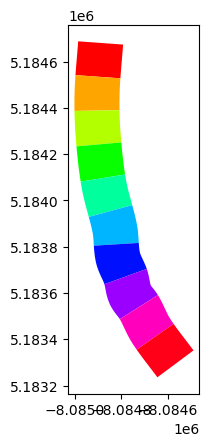

In [187]:
testy.plot(cmap='hsv')

In [195]:
testy = gpd.GeoDataFrame(geometry=testy)

In [196]:
testy

,geometry
0,"POLYGON ((-8084793.375 5184660.379, -8084793.4..."
1,"POLYGON ((-8084804.23 5184525.979, -8084805.06..."
2,"POLYGON ((-8084807.797 5184385.849, -8084807.5..."
3,"POLYGON ((-8084799.436 5184244.146, -8084798.2..."
4,"POLYGON ((-8084782.299 5184103.564, -8084780.2..."
5,"POLYGON ((-8084749.736 5183968.611, -8084749.5..."
6,"POLYGON ((-8084724.561 5183816.472, -8084723.6..."
7,"POLYGON ((-8084871.789 5183638.415, -8084690.1..."
8,"POLYGON ((-8084639.274 5183586.846, -8084635.9..."
9,"POLYGON ((-8084570.31 5183461.331, -8084563.10..."


In [204]:
# Get pixels in reach
inside = gpd.sjoin(gdf_PIXC, testy, how='inner',
                   predicate='within').rename(columns={'index_right': 'segment'})

if inside.empty:
    prop = 0
else:    
    # Get number of pixels in each reach segment
    counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
    print(counts)
    # Calculate coverage (proportion of reaches with >= 1 pixel in them)
    prop = len(counts.loc[counts['count'] != 0])/10
    print(prop)
# return prop

   segment  count
0        9     29
1        6     27
2        8     26
3        5     26
4        3     23
5        7     21
6        1     12
7        4     11
8        2     11
0.9


In [199]:
inside

,klass,geometry,index_right
314779,4.0,POINT (-8084648.72 5183245.708),9
315409,4.0,POINT (-8084674.037 5183282.269),9
315410,4.0,POINT (-8084648.543 5183275.891),9
315411,4.0,POINT (-8084610.499 5183266.371),9
316034,5.0,POINT (-8084704.832 5183320.186),9
...,...,...,...
337046,5.0,POINT (-8084885.594 5184483.85),1
337047,5.0,POINT (-8084824.49 5184468.559),1
337048,5.0,POINT (-8084839.167 5184472.234),1
337607,5.0,POINT (-8084864.844 5184508.888),1


**TESTING**

In [88]:
test = basin_crop[basin_crop['GNIS_Name'] == 'Fort River'].sample(n=1)
test

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
58014,"(20, 30]",Fort River,1.464,1.000090e+13,21.810459,"LINESTRING (-8072279.293 5214944.614, -8072290..."


In [89]:
test.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [90]:
# Try with apply()
# test['segments'] = test.apply(segmentReach, axis=1)

test['segments'] = test.apply(func=segmentReach, axis=1)

In [91]:
test

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry,segments
58014,"(20, 30]",Fort River,1.464,1.000090e+13,21.810459,"LINESTRING (-8072279.293 5214944.614, -8072290...",[LINESTRING (-8072279.292689738 5214944.614315...


In [92]:
test.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [93]:
test = test.rename(columns={'geometry': 'geometry_full'}).set_geometry('geometry_full')

In [94]:
assert test.geometry.name == 'geometry_full'

**Inside Function**

In [95]:
test = test.explode(column='segments').reset_index()

In [96]:
test.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [97]:
# Set segments as the active geometry column, set CRS as it is somehow dropped
test = test.set_geometry('segments').set_crs(crs=basin_crop.crs)

In [98]:
test.geometry.name

'segments'

In [99]:
test.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [100]:
test['segments_buff'] = test.geometry.buffer(distance=(test.WidthM/2)[0], cap_style='flat')

In [101]:
test = test.set_geometry('segments_buff')

In [102]:
test.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

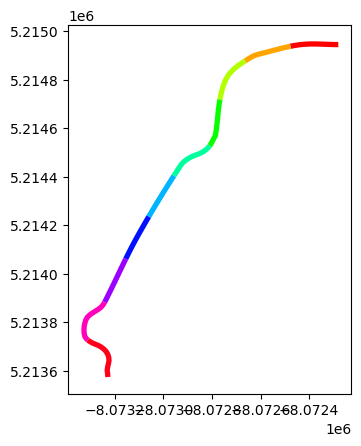

In [103]:
test.plot(cmap='hsv')

In [104]:
inside = gpd.sjoin(gdf_PIXC, test, how='inner', predicate='within').rename(columns={'index_right': 'segment'})


In [105]:
inside.geometry.name

'geometry'

In [107]:
if inside.empty:
    prop = 0
else:    
    # Get number of pixels in each reach segment
    counts = pd.DataFrame(inside.segments.value_counts().reset_index().sort_index())
    print(counts)
    # Calculate coverage
    prop = len(counts.loc[counts['count'] != 0])/10
    print(prop)

                                            segments  count
0  LINESTRING (-8072663.681 5214877.028, -8072670...      4
1  LINESTRING (-8073311.132 5213726.603, -8073305...      2
2  LINESTRING (-8072956.958 5214403.522, -8072963...      2
3  LINESTRING (-8073242.164 5213883.159, -8073242...      1
4  LINESTRING (-8073060.785 5214234.964, -8073062...      1
5  LINESTRING (-8072809.554 5214527.463, -8072813...      1
6  LINESTRING (-8072767.261 5214717.998, -8072767...      1
7  LINESTRING (-8072476.578 5214937.534, -8072478...      1
0.8


In [130]:
# test['new_index'] = test.groupby('index').cumcount()

In [ ]:
# test.iloc[0:10].apply(func=getCoverage)

In [ ]:
# test['coverage'] = test.apply(func=getCoverage)

#### TESTING

In [22]:
# Initialize lists
coverage = []
reach_bins = []

In [23]:
binn = bins[2]
binn

'(150, 200]'

In [24]:
reach = basin_crop.loc[basin_crop['Bin'] == binn].sample(n=1)

In [25]:
reach

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
64496,"(150, 200]",Connecticut River,1.663,1.000090e+13,191.781368,"LINESTRING (-8083489.406 5213595.38, -8083505...."


<Axes: >

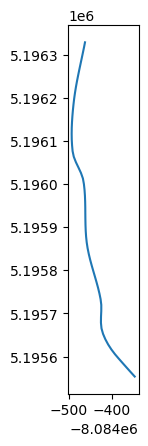

In [134]:
reach.plot()

In [135]:
reach_bins.append(reach.iloc[0,0])

In [136]:
reach_bins

['(150, 200]', '(150, 200]']

<Axes: >

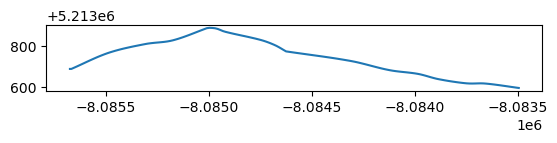

In [26]:
# Convert MultiLineString Z to LineString (returns GeoSeries)
gs = reach.geometry
gs.plot()

In [27]:
gs

64496    LINESTRING (-8083489.406 5213595.38, -8083505....
Name: geometry, dtype: geometry

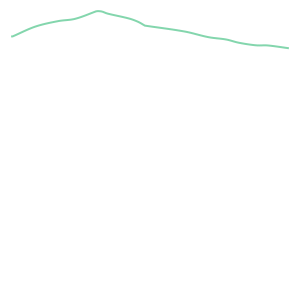

In [28]:
# Extract line segment from GeoSeries
line = gs[reach.index[0]]
line

In [139]:
print(line.length)

817.5229342573197


In [31]:
# Find length of segments
dist = line.length/10
print(dist)

225.97472903513147


In [32]:
# Make empty list for segments
segments = []

In [54]:
# Segment the reach
for i in range(9):
    # Chop the reach, store remainder
    new, line = cut(line=line, distance=dist)
    # Append new segment to GeoSeries of all segments
    segments.append(new)
# Append final segment of reach   
segments.append(line)

In [55]:
segments

[<LINESTRING (-8083489.406 5213595.38, -8083505.57 5213597.539, -8083518.951 ...>,
 <LINESTRING (-8083713.872 5213617.65, -8083720.506 5213617.522, -8083734.02 ...>,
 <LINESTRING (-8083936.494 5213652.436, -8083946.521 5213655.319, -8083959.59...>,
 <LINESTRING (-8084158.901 5213690.418, -8084159.542 5213690.566, -8084172.67...>,
 <LINESTRING (-8084379.499 5213738.698, -8084383.903 5213739.4, -8084397.261 ...>,
 <LINESTRING (-8084603.217 5213770.535, -8084611.388 5213771.725, -8084624.74...>,
 <LINESTRING (-8084814.588 5213845.193, -8084826.175 5213847.712, -8084839.41...>,
 <LINESTRING (-8085033.136 5213877.579, -8085034.966 5213876.895, -8085047.62...>,
 <LINESTRING (-8085249.538 5213816.665, -8085255.304 5213816.16, -8085268.826...>,
 <LINESTRING (-8085470.669 5213771.825, -8085480.058 5213768.922, -8085492.84...>]

In [57]:
# Make dict for constructing new GeoDataFrame
d = {}

In [58]:
for i in range(reach.shape[1]):
    d[reach.iloc[:,i].name] = reach.iloc[0,i]

In [59]:
d

{'Bin': '(150, 200]',
 'GNIS_Name': 'Connecticut River',
 'LengthKM': np.float64(1.663),
 'NHDPlusID': np.float64(10000900065602.0),
 'WidthM': np.float64(191.78136792049477),
 'geometry': <LINESTRING (-8083489.406 5213595.38, -8083505.57 5213597.539, -8083518.951 ...>}

In [ ]:
# Rename geometry for full reach
d['geometry_full'] = d['geometry']

In [ ]:
# Make GeoDataFrame with new reach segments
reach_cut = gpd.GeoDataFrame(data=d, index=range(len(segments)),
                             geometry=segments, crs=reach.crs)

In [145]:
reach_cut

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry,geometry_full
0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084462.395 5196331.153, -8084464...",LINESTRING (-8084462.394799335 5196331.1526111...
1,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084478.966 5196251.099, -8084481...",LINESTRING (-8084462.394799335 5196331.1526111...
2,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084490.999 5196170.283, -8084492...",LINESTRING (-8084462.394799335 5196331.1526111...
3,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084492.726 5196088.648, -8084491...",LINESTRING (-8084462.394799335 5196331.1526111...
4,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084467.432 5196011.574, -8084465...",LINESTRING (-8084462.394799335 5196331.1526111...
5,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084462.072 5195930.128, -8084461...",LINESTRING (-8084462.394799335 5196331.1526111...
6,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084456.281 5195848.703, -8084454...",LINESTRING (-8084462.394799335 5196331.1526111...
7,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084435.355 5195769.707, -8084432...",LINESTRING (-8084462.394799335 5196331.1526111...
8,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084425.743 5195689.095, -8084425...",LINESTRING (-8084462.394799335 5196331.1526111...
9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,"LINESTRING (-8084399.485 5195613.583, -8084393...",LINESTRING (-8084462.394799335 5196331.1526111...


<Axes: >

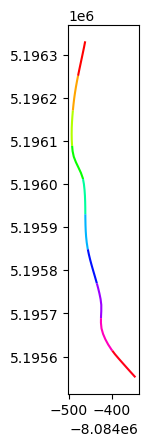

In [146]:
gpd.GeoSeries(segments).plot(cmap='hsv')

<Axes: >

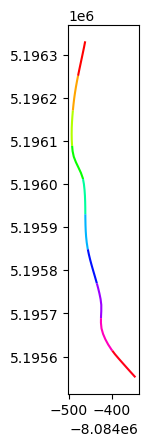

In [147]:
reach_cut.plot(cmap='hsv')

In [148]:
# Buffer the reach segments by 1/2 the calculated width
# CITE BEIGER
reach_cut['geometry'] = reach_cut.geometry.buffer(distance=(reach_cut.WidthM/2)[0], cap_style='flat')

<Axes: >

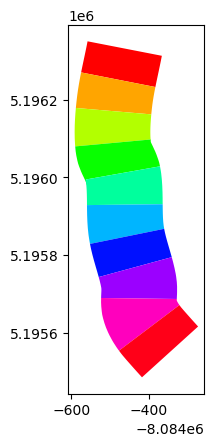

In [149]:
reach_cut.plot(cmap='hsv')

In [150]:
# Get pixels in reach
inside = gpd.sjoin(gdf_PIXC, reach_cut, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

In [151]:
inside

,klass,geometry,segment,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry_full
551554,2.0,POINT (-8084426.802 5195500.297),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
551557,5.0,POINT (-8084413.217 5195496.899),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
552054,5.0,POINT (-8084440.054 5195533.887),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
552055,5.0,POINT (-8084393.322 5195522.185),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
552056,4.0,POINT (-8084406.989 5195525.61),9,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
...,...,...,...,...,...,...,...,...,...
566534,4.0,POINT (-8084526.541 5196342.508),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
566535,4.0,POINT (-8084486.889 5196332.579),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
566536,4.0,POINT (-8084452.007 5196323.879),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...
566537,4.0,POINT (-8084414.85 5196314.574),0,"(150, 200]",Connecticut River,0.608,1.000090e+13,194.436072,LINESTRING (-8084462.394799335 5196331.1526111...


<Axes: >

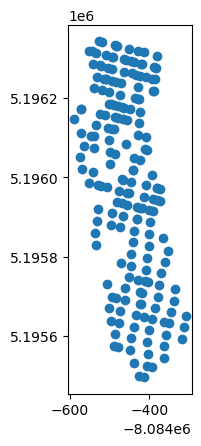

In [155]:
inside.plot()

In [ ]:
if inside.empty:
    coverage = 0
else:    
    # Get number of pixels in each reach segment
    counts = pd.DataFrame(inside.segment.value_counts().reset_index().sort_index())
    print(counts)
    # Calculate coverage
    coverage = len(counts.loc[counts['count'] != 0])/len(counts.segment)